In [128]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [129]:
def find_structural_equivalent_nodes(graph):
    structural_equivalent = []
    nodes = list(graph.nodes())
    while nodes:
        node = nodes[0]
        equivalent = [node]
        neighbors = set(graph.neighbors(node))
        nodes.remove(node)
        i = 0
        while i < len(equivalent):
            curr_node = equivalent[i]
            for n in nodes[:]:
                if neighbors == set(graph.neighbors(n)):
                    equivalent.append(n)
                    nodes.remove(n)
            i += 1
        if len(equivalent) > 1:
            structural_equivalent.append(equivalent)
    return structural_equivalent

def find_common_neighbor_equivalent_nodes(graph):
    common_neighbor_equivalent = []
    nodes = list(graph.nodes())
    while nodes:
        node = nodes[0]
        equivalent = [node]
        neighbors = set(graph.neighbors(node))
        nodes.remove(node)
        i = 0
        while i < len(equivalent):
            curr_node = equivalent[i]
            curr_neighbors = set(graph.neighbors(curr_node))
            for n in nodes[:]:
                if len(curr_neighbors.intersection(set(graph.neighbors(n)))) == len(neighbors):
                    equivalent.append(n)
                    nodes.remove(n)
            i += 1
        if len(equivalent) > 1:
            common_neighbor_equivalent.append(equivalent)
    return common_neighbor_equivalent

def find_edge_equivalent_nodes(graph):
    edge_equivalent = []
    edges = list(graph.edges())
    while edges:
        edge = edges[0]
        equivalent = [edge]
        nodes = set(edge)
        edges.remove(edge)
        i = 0
        while i < len(equivalent):
            curr_edge = equivalent[i]
            for e in edges[:]:
                if set(e).intersection(nodes) == nodes:
                    equivalent.append(e)
                    nodes.update(e)
                    edges.remove(e)
            i += 1
        if len(equivalent) > 1:
            edge_equivalent.append(equivalent)
    return edge_equivalent

In [130]:
def equivalence_pipeline(graph):
    equivalence_functions = [
        find_structural_equivalent_nodes,
        find_common_neighbor_equivalent_nodes,
        find_edge_equivalent_nodes
    ]

    all_groups = []

    for func in equivalence_functions:
        equivalent_nodes = func(graph)
        all_groups.extend(equivalent_nodes)

    
    num_groups = len(all_groups)

    new_colors = plt.cm.tab10.colors + plt.cm.Set3.colors + plt.cm.Paired.colors
    new_colors = new_colors[:num_groups]
    new_colormap = mcolors.ListedColormap(new_colors)

    for func in equivalence_functions:
        equivalent_nodes = func(graph)
        
        color_map = {}
        for i, nodes in enumerate(equivalent_nodes):
            for node in nodes:
                color_map[node] = i

        default_color = len(equivalent_nodes)
        for node in graph.nodes():
            if node not in color_map:
                color_map[node] = default_color

        pos = nx.spring_layout(graph, seed=23768)

        plt.figure(figsize=(42, 42))
        node_colors = [color_map[node] for node in graph.nodes()]
        nx.draw(graph, pos, node_color=node_colors, with_labels=False, cmap=new_colormap)
        plt.show()

In [131]:
df1 = pd.read_csv('data/Postings_01052019_15052019.csv', sep=';')
df2 = pd.read_csv('data/Postings_16052019_31052019.csv', sep=';')
df = pd.concat([df1, df2], ignore_index=True)
df = df[['ID_CommunityIdentity', 'ID_Posting', 'ID_Posting_Parent']]

In [132]:
comment_user_mapping = df[['ID_Posting', 'ID_CommunityIdentity']].drop_duplicates().rename(columns={'ID_Posting':'Id_posting', 'ID_CommunityIdentity': 'ID_ParentIdentity'})

result_df = pd.merge(df, comment_user_mapping, left_on='ID_Posting_Parent', right_on='Id_posting', how='left')
result_df = result_df[['ID_CommunityIdentity', 'ID_ParentIdentity']]
reply_counts = result_df.groupby(['ID_CommunityIdentity', 'ID_ParentIdentity']).size().reset_index(name='counts')

reply_counts = reply_counts[:300]

In [133]:
G = nx.from_pandas_edgelist(reply_counts, 
                            source='ID_CommunityIdentity', 
                            target='ID_ParentIdentity', 
                            edge_attr = 'counts',
                            create_using=nx.Graph())

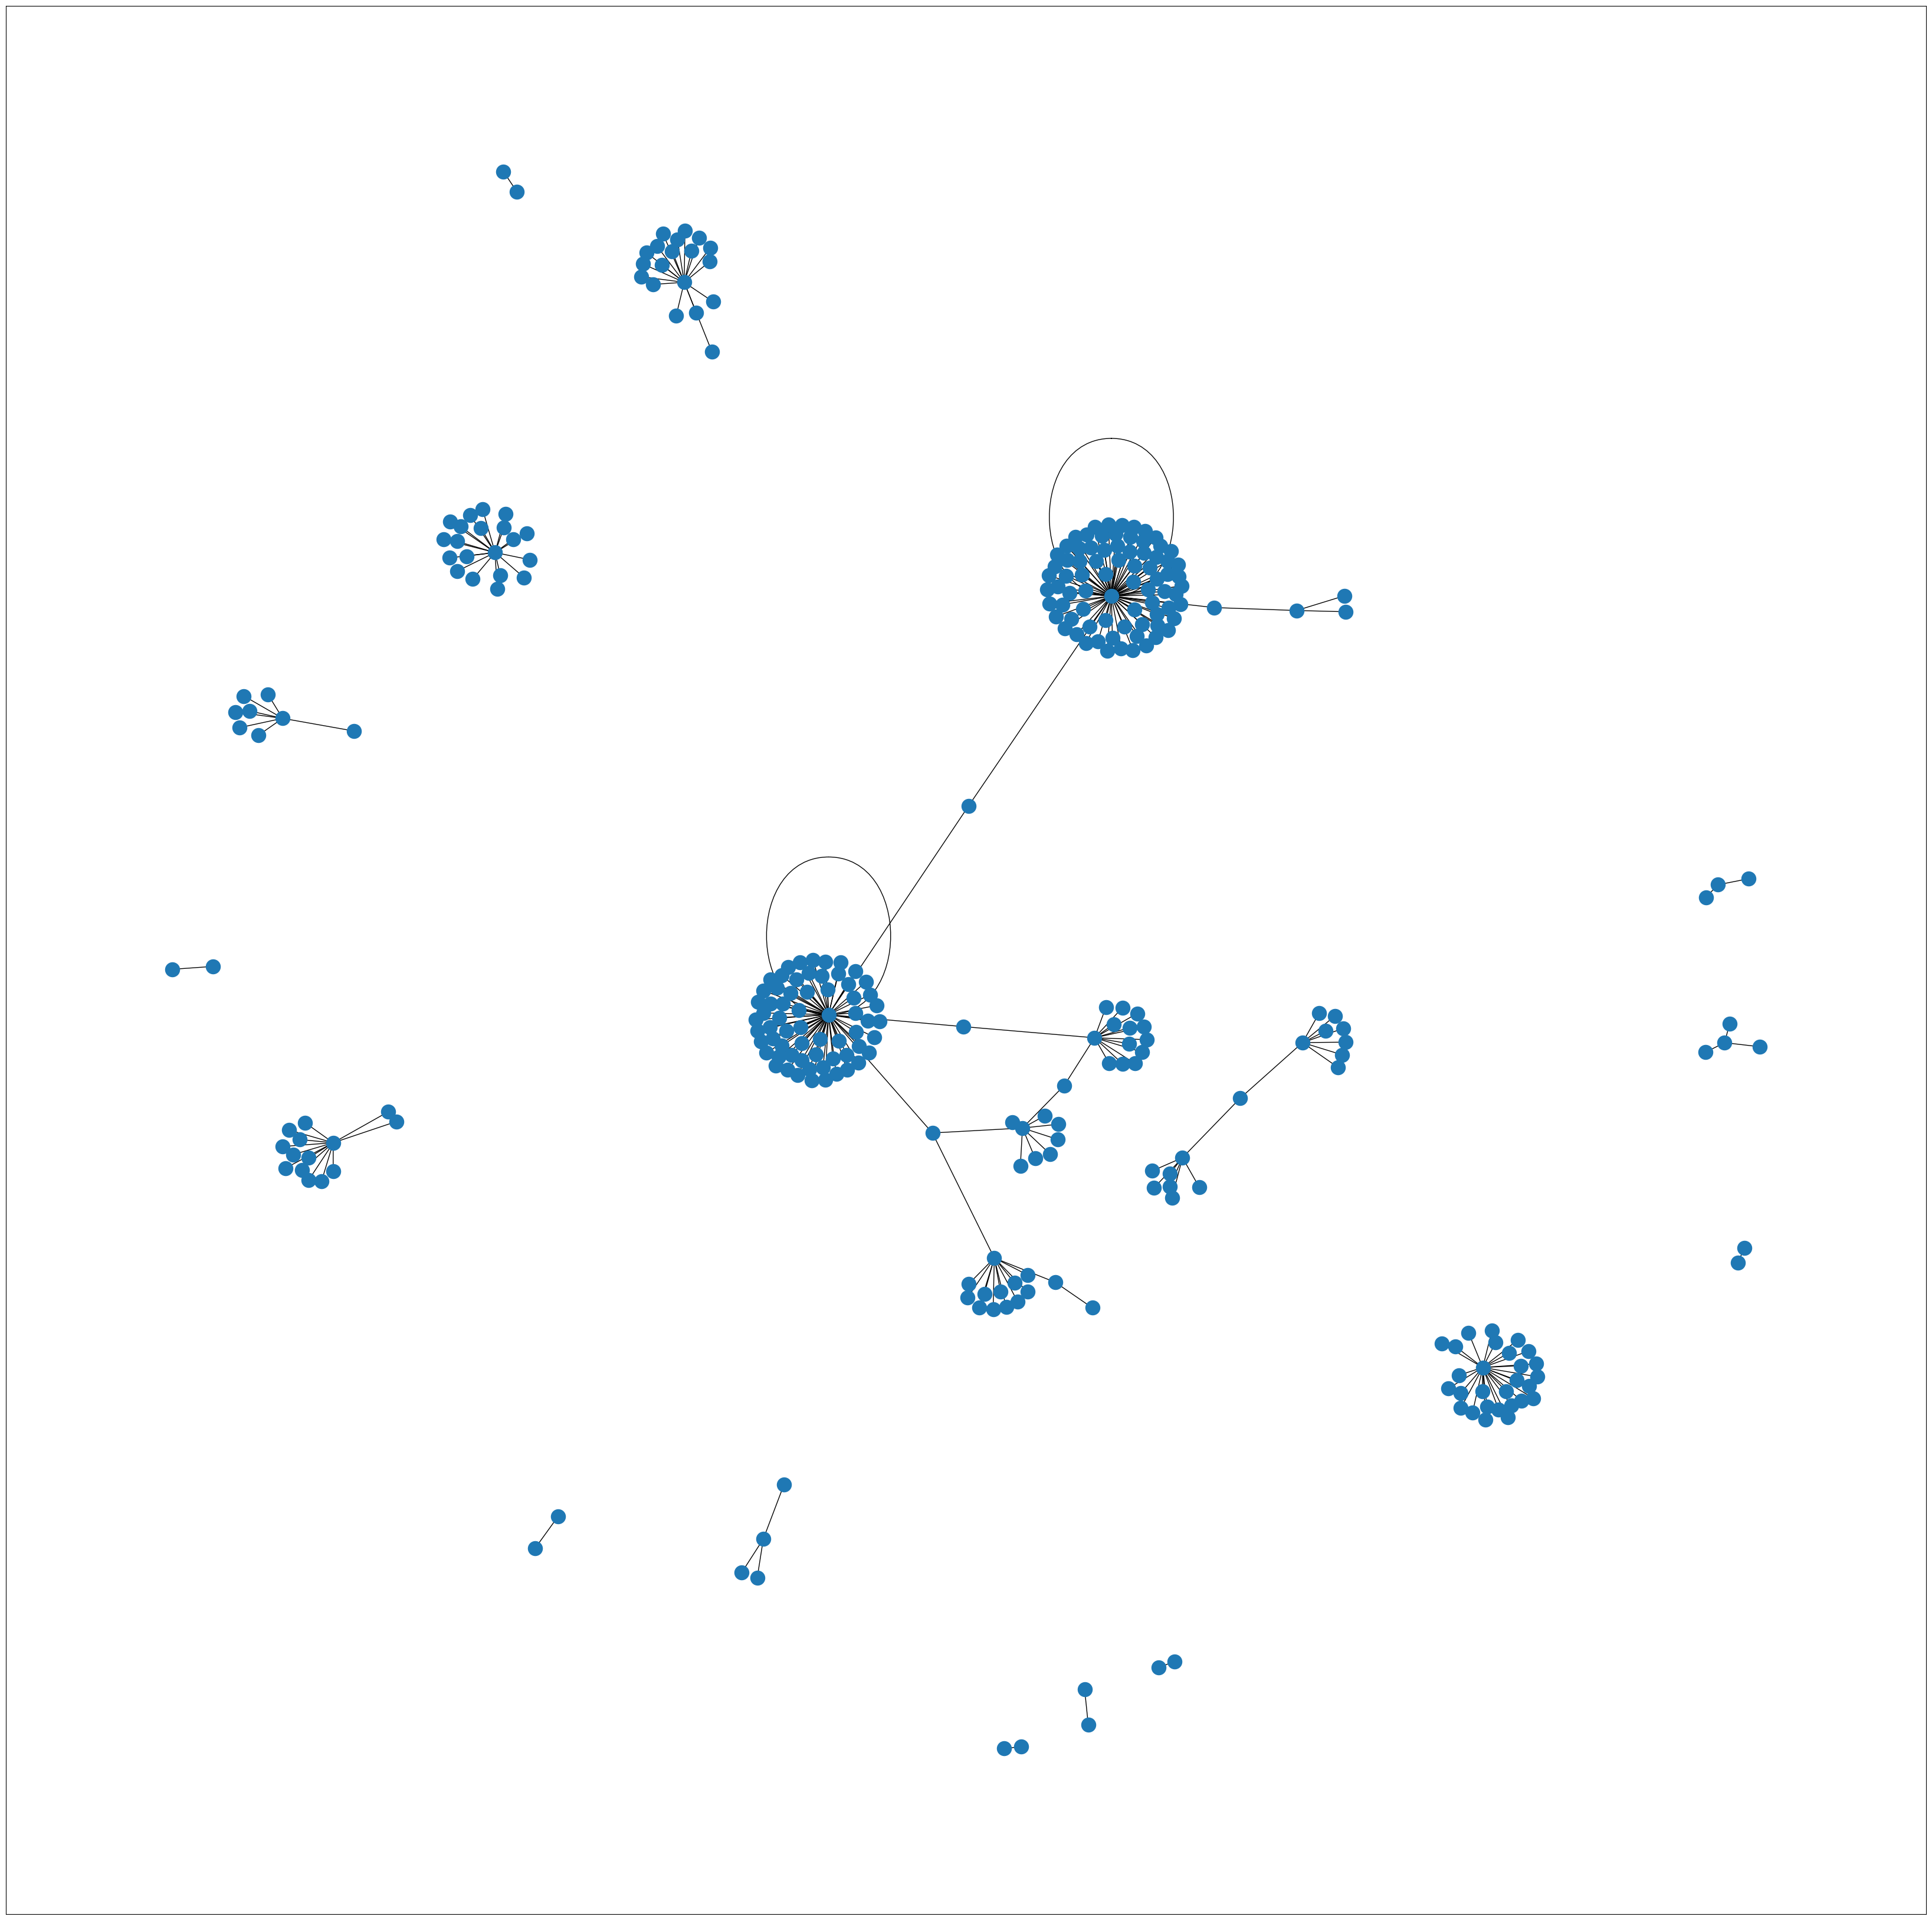

In [134]:
fig = plt.figure(figsize=(42,42))
nx.draw_networkx(G, with_labels=False)
plt.show()

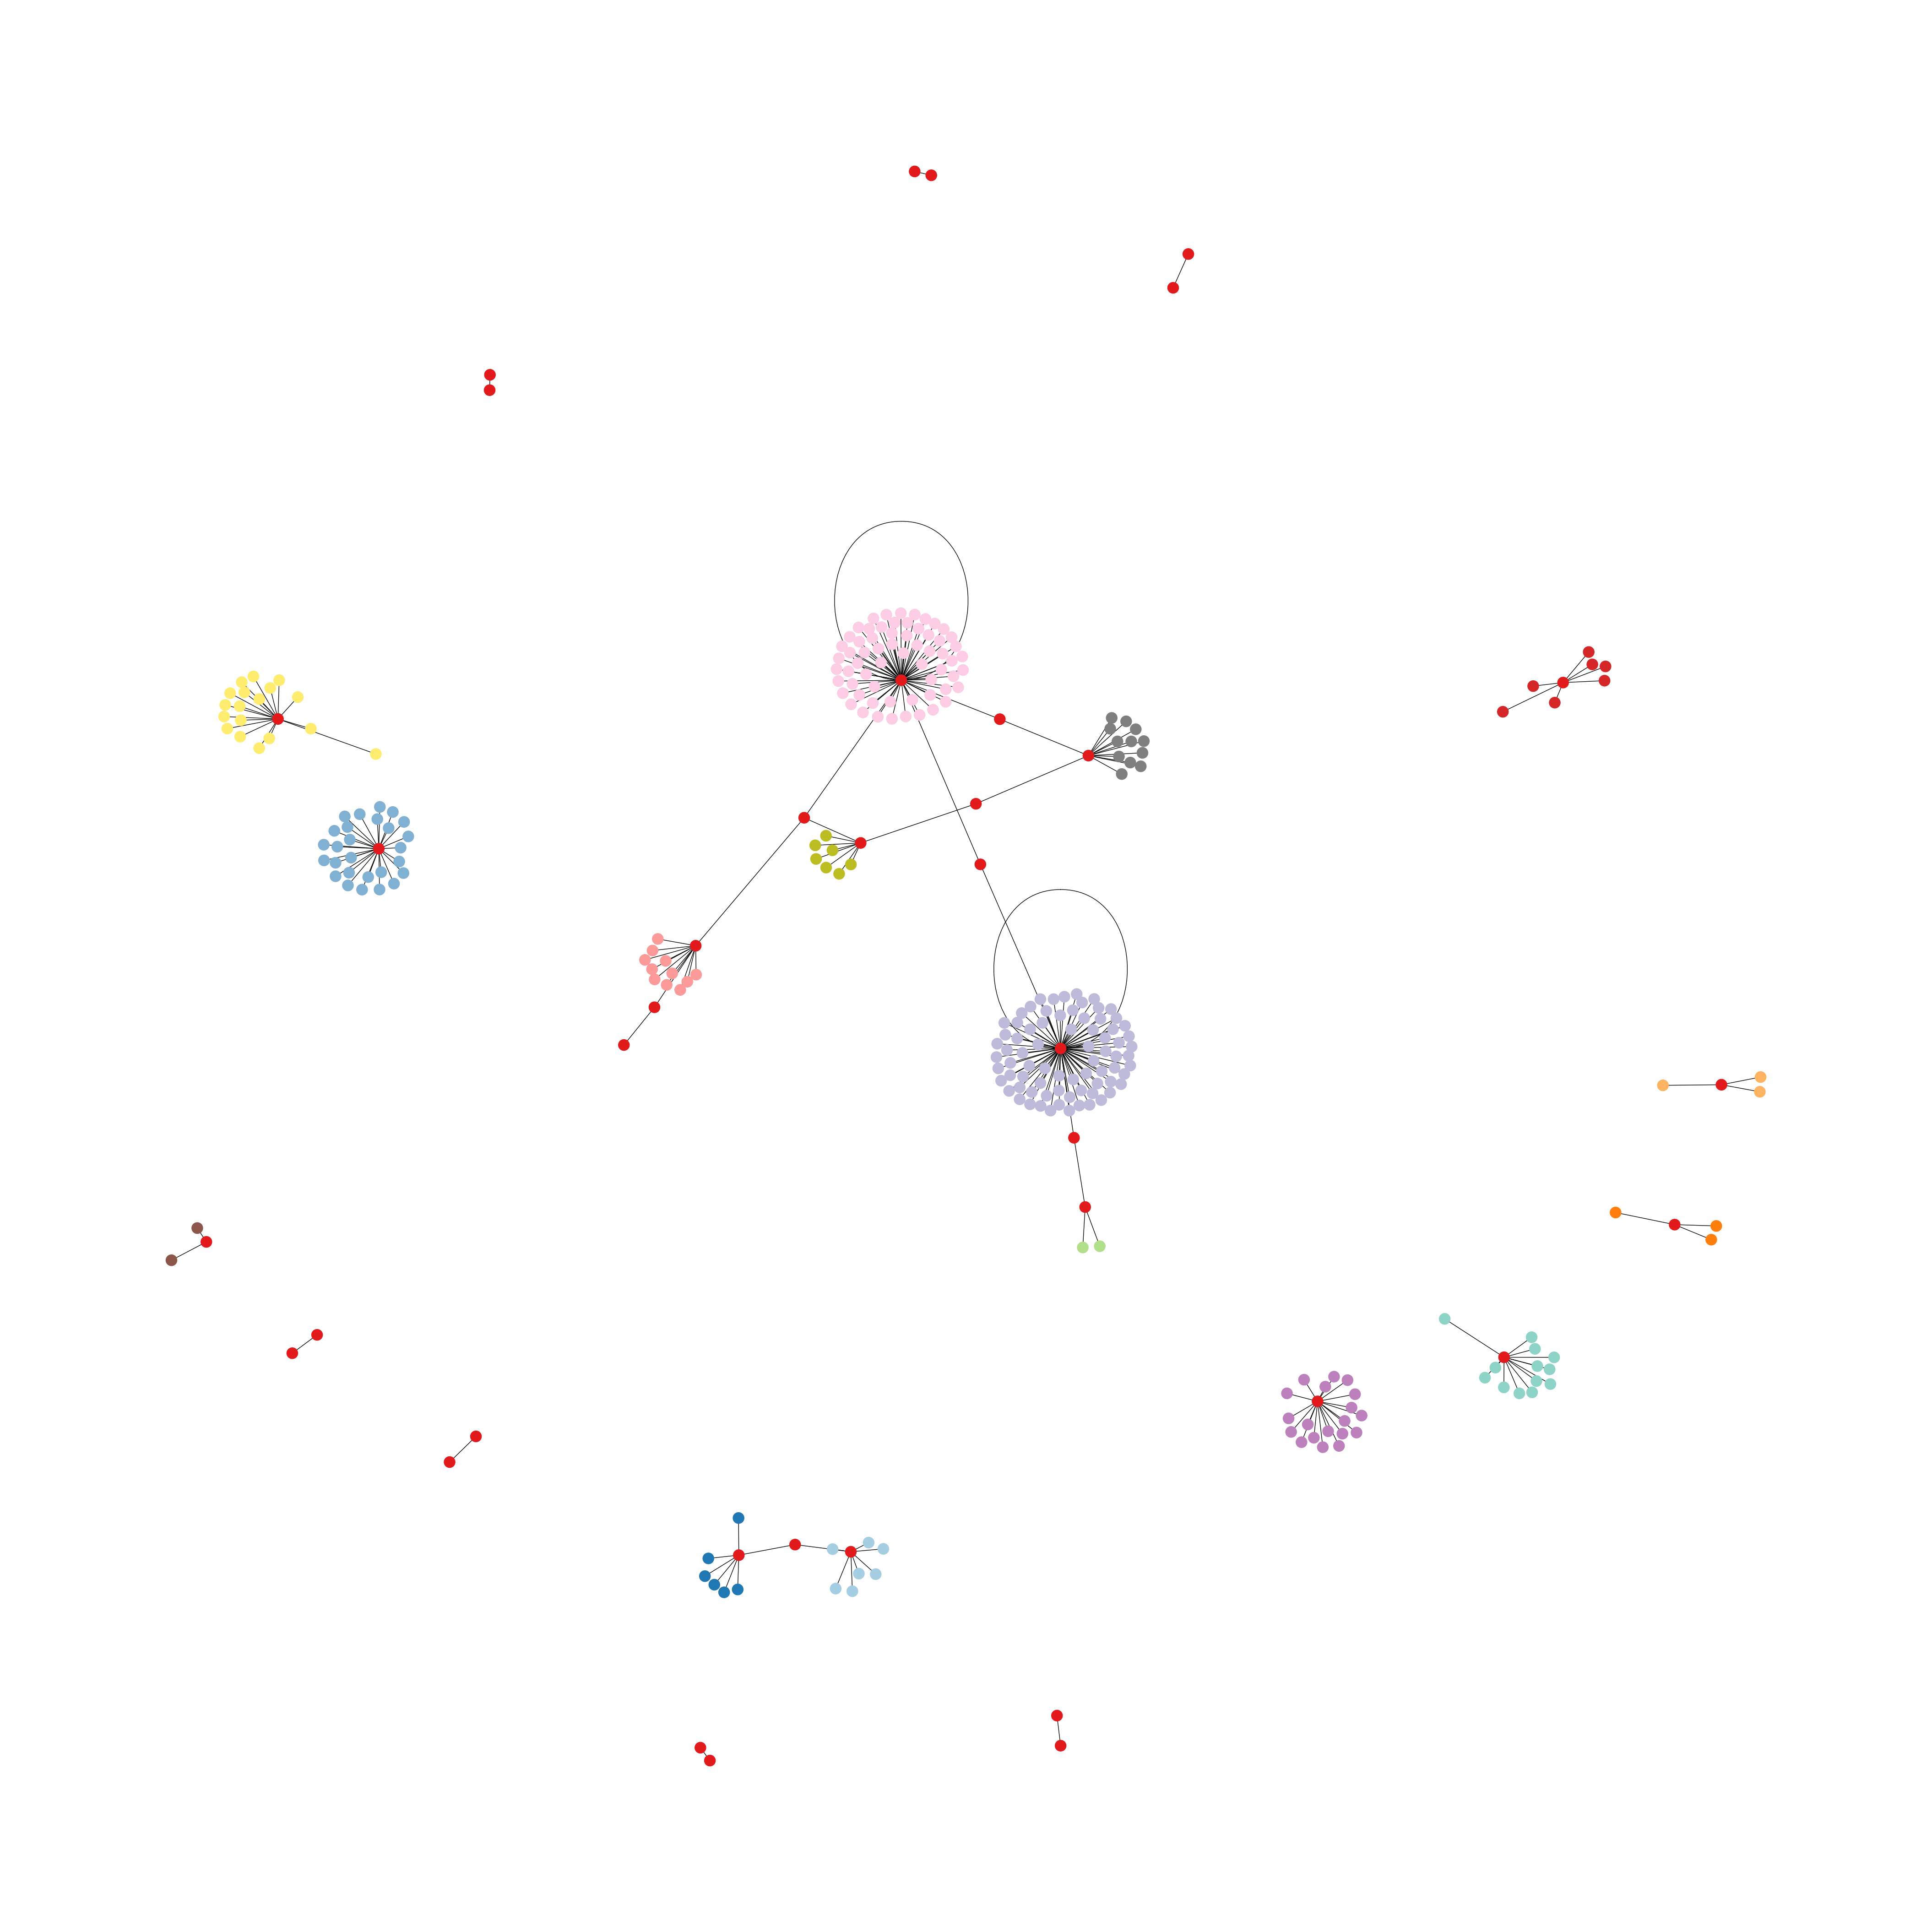

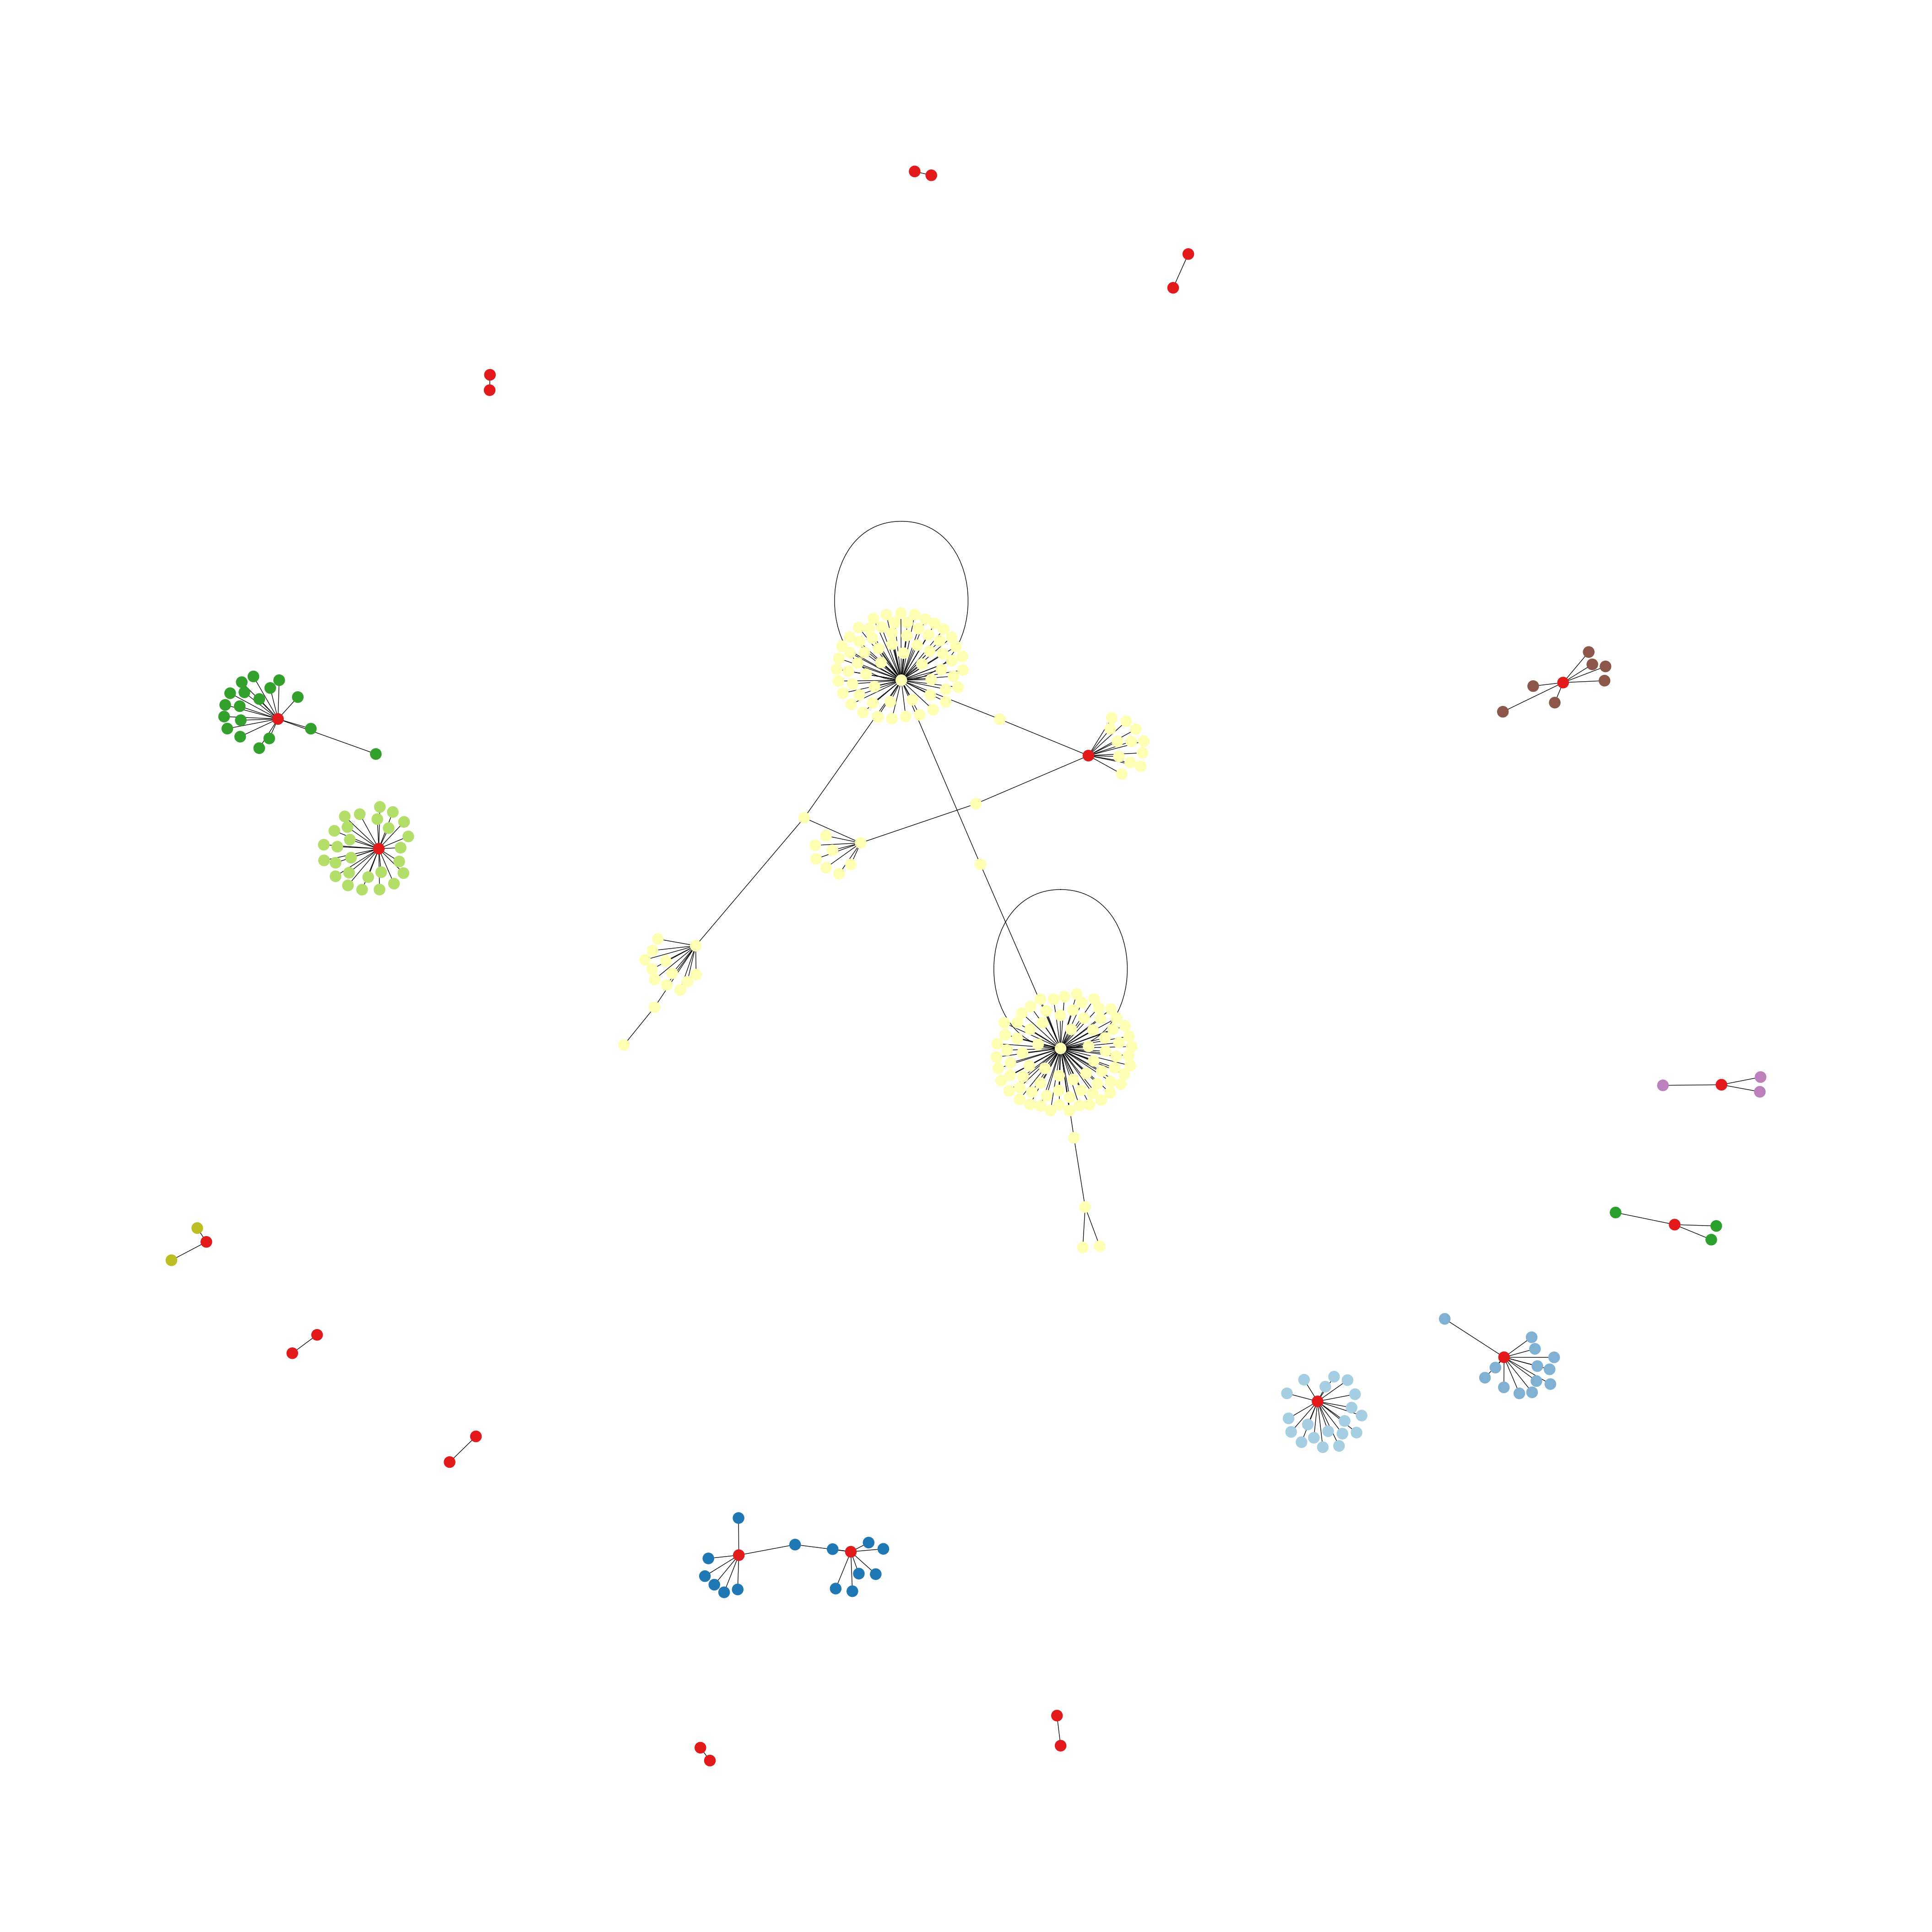

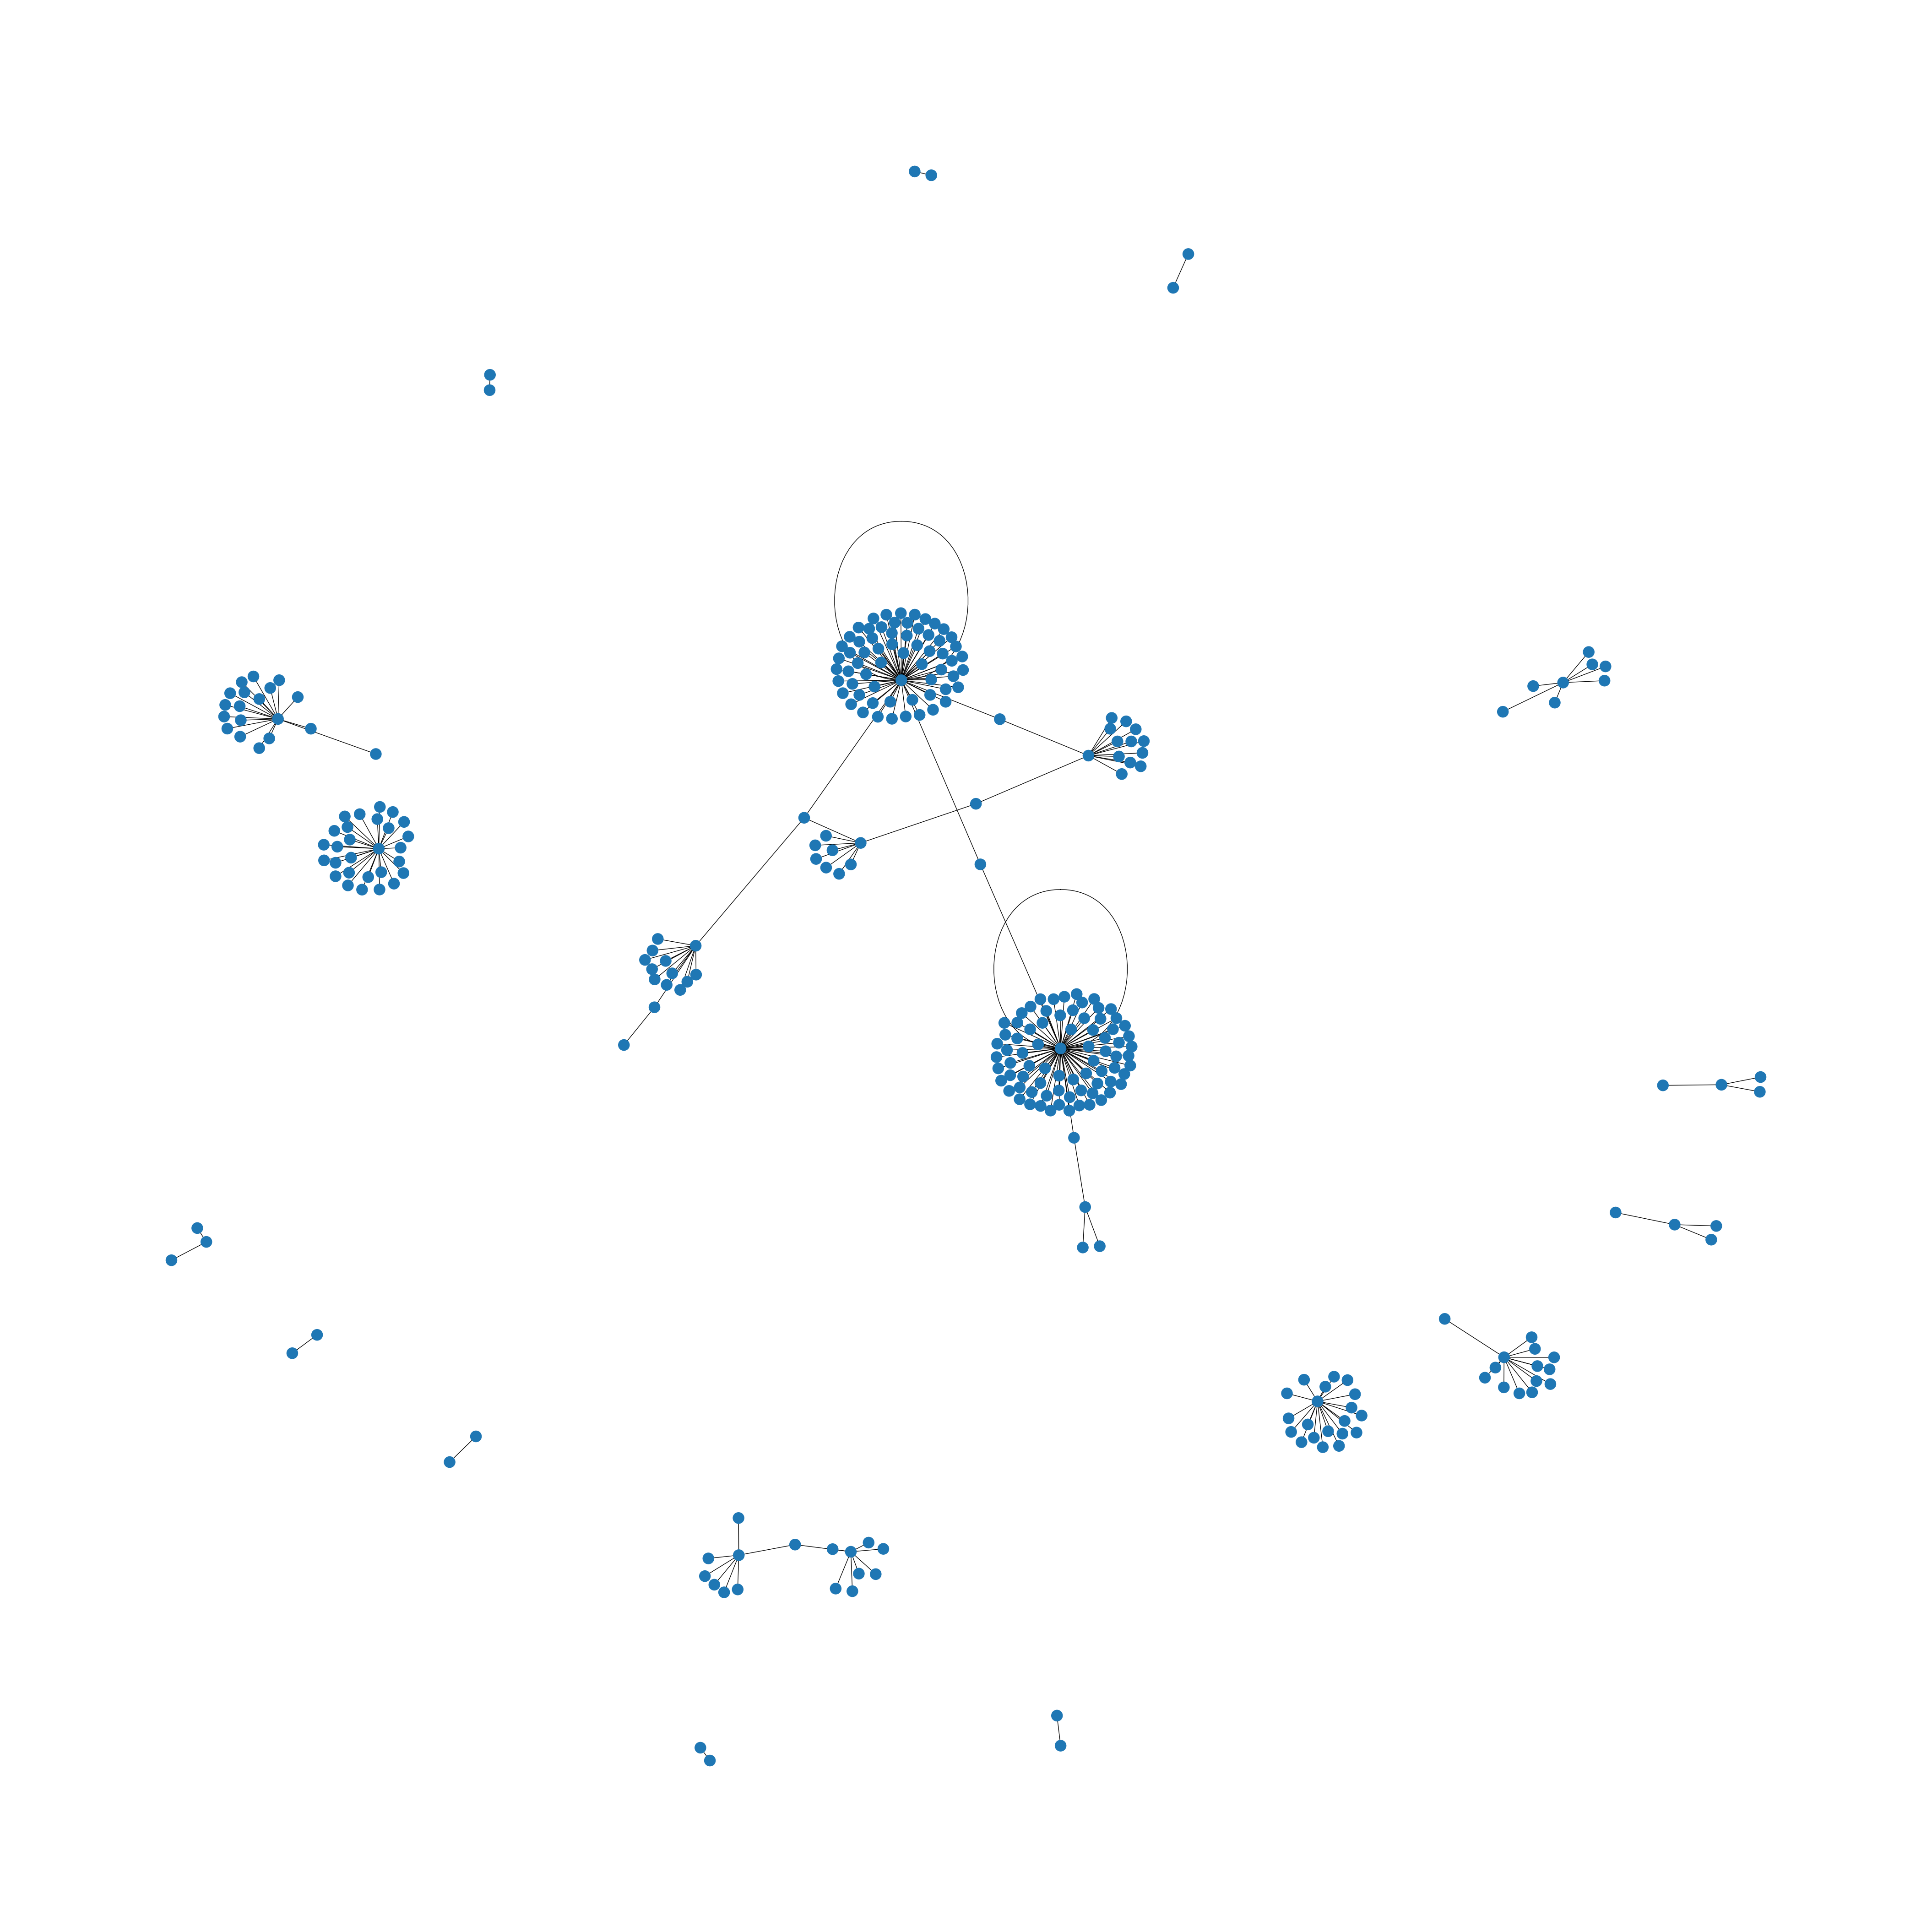

In [135]:
equivalence_pipeline(G)